In [1]:
import os
# Print working directory
print(os.getcwd())
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from train import get_model_class
from similarity_metrics import get_top_k, average_pairwise_score, top_k_sa
import torch
%load_ext autoreload
%autoreload 2

/Users/lena/modconn/harvard_cs282_ptg/ptg


In [6]:
def get_model_from_curve(curve, t):
    # Get the state_dict at t
    state_dict_values = curve.get_weights(t=t)
    state_dict = torch.load(f'{directory}/{random_source}_model_{0}.pth')
    for i, key in enumerate(state_dict.keys()):
        state_dict[key] = state_dict_values[i]
    # Create the model
    m = model_class(*model_args)
    m.load_state_dict(state_dict)
    return m

def get_pairwise_curves(model_idx):
    # Takes in list of model indices, and constructs curves between each pair of models
    # Returns a list of curves
    p_curves = []
    for i in range(len(model_idx)-1):
        for j in range(i+1, len(model_idx)):
            
            p_curve = train_curve(trainloader=trainloader, num_classes=23, model_class=TabularModel,
                                  curve_class=TabularModelCurve, curve=curves.PolyChain, num_bends=5,
                                  init_start=f'{directory}/{random_source}_model_{i}.pth',
                                  init_end=f'{directory}/{random_source}_model_{j}.pth', fix_start=True,
                                  fix_end=True, model_args=[0.0], lr=0.1, momentum=0.9, epochs=20)
            
            p_curves.append(p_curve)
    return p_curves

def get_curves_gradients(p_curves, ts=np.linspace(0.0, 1.0, 101)):
    # Takes in list of curves, and computes gradients for each curve at each point on the curve
    # Returns a list of gradients
    curve_grads = np.zeros((len(p_curves), len(ts), *X_test.shape))
    for i, p_curve in enumerate(p_curves):
        for j, t in enumerate(ts):
            model = get_model_from_curve(curve=p_curve, t=t)
            curve_grads[i,j] = model.compute_gradients(X_test, return_numpy=True)
    return curve_grads

# Datasets

In [2]:
from modconn.modconn import train_curve
import datasets
from datasets.tabular import TabularModel, TabularModelCurve
from modconn import curves
from torch.utils.data import DataLoader
from datasets.tabular import layers
dname = 'heloc'
trainset, testset = datasets.load_dataset(dname)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

In [3]:
name = 'heloc'  # or 'german'
random_source = 'rs'
n_models = 1000  # 1000 for german if needed
trainset, testset = datasets.load_dataset(name)

X_test, y_test = testset.data.numpy(), testset.labels.numpy()
X_train, y_train = trainset.data.numpy(), trainset.labels.numpy()
n_inputs, input_size = X_test.shape
model_args = [input_size, datasets.tabular.layers[name]]
model_class = get_model_class(name)
directory = f'models/{name}'
directory

'models/heloc'

# Train Curve

In [12]:
p_curve = train_curve(trainloader=trainloader,
                      num_classes=23,
                      model_class=TabularModel,
                      curve_class=TabularModelCurve,
                      curve=curves.PolyChain,
                      num_bends=5,
                      init_start=f'{directory}/{random_source}_model_{0}.pth',
                      init_end=f'{directory}/{random_source}_model_{1}.pth',
                      fix_start=True,
                      fix_end=True,
                      model_args=[0.0],
                      lr=0.1,
                      momentum=0.9,
                      epochs=20)

KeyboardInterrupt: 

### Compute Curve Accuracies

In [ ]:
# For each point on the curve, compute accuracies
ts = np.linspace(0.0, 1.0, 1001)
curve_accs = np.zeros(len(ts))
curve_accs_tr = np.zeros(len(ts))
for i, t in enumerate(tqdm(ts)):
    a = p_curve(torch.from_numpy(X_test).float(), t=t)
    curve_accs[i] = (a.argmax(1)==torch.from_numpy(y_test)).float().mean()
    a = p_curve(torch.from_numpy(X_train).float(), t=t)
    curve_accs_tr[i] = (a.argmax(1)==torch.from_numpy(y_train)).float().mean()

100%|██████████| 1001/1001 [00:04<00:00, 237.74it/s]


### Compute Segment Accuracies

In [ ]:
def linear_weight_interpolation(state_dict1, state_dict2, ts):
    # Interpolate between two state dicts
    state_dicts = []
    for t in ts:
        state_dict = {}
        for key in state_dict1.keys():
            state_dict[key] = state_dict1[key] + (state_dict2[key] - state_dict1[key]) * t
        state_dicts.append(state_dict)
    return state_dicts

In [ ]:
# Interpolate between two state dicts
state_dict1 = torch.load(f'{directory}/{random_source}_model_{0}.pth')
state_dict2 = torch.load(f'{directory}/{random_source}_model_{1}.pth')
state_dicts = linear_weight_interpolation(state_dict1, state_dict2, ts)

# For each state dict, compute the accuracy on the test set
accuracies = []
accuracies_tr = []
for state_dict in tqdm(state_dicts):
    model = model_class(*model_args)
    model.load_state_dict(state_dict)
    accuracies.append((model.predict(X_test).numpy() == y_test).mean())
    accuracies_tr.append((model.predict(X_train).numpy() == y_train).mean())

100%|██████████| 1001/1001 [00:03<00:00, 279.05it/s]


### Plot Results

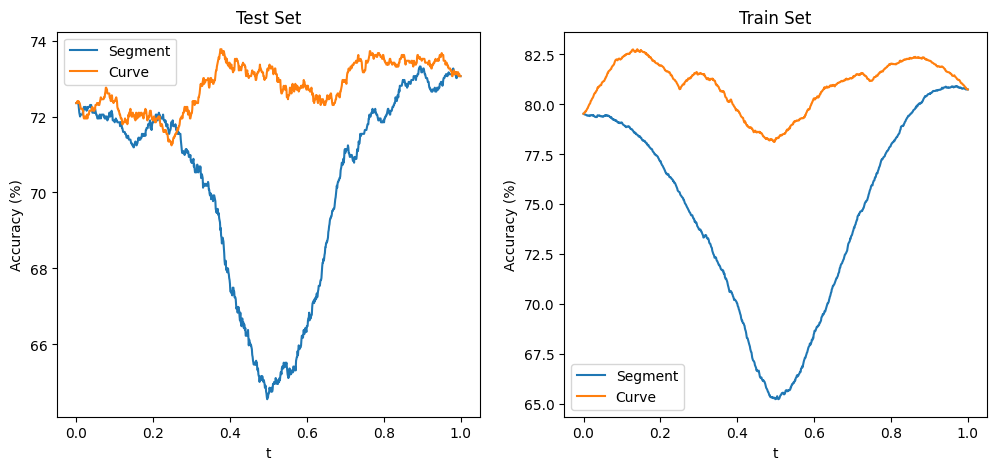

In [ ]:
# Plot both plots below on one row, two columns
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
accs = [accuracies, accuracies_tr]
c_accs = [curve_accs, curve_accs_tr]
labs = ['Test Set', 'Train Set']

for i in range(2):
    ax[i].plot(ts, 100*np.array(accs[i]), label='Segment')
    ax[i].plot(ts, 100*np.array(c_accs[i]), label='Curve')
    ax[i].set_xlabel('t')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_title(labs[i])
    ax[i].legend()
plt.show()

# Analyse Curve

In [ ]:
# For each point on the curve, compute accuracies
ts = np.linspace(0.0, 1.0, 1001)
curve_grads = np.zeros((len(ts), *X_test.shape))
for i, t in enumerate(tqdm(ts)):
    model = get_model_from_curve(curve=p_curve, t=t)
    curve_grads[i] = model.compute_gradients(X_test, return_numpy=True)
tk_curve, s_curve = get_top_k(5, curve_grads, return_sign=True)

100%|██████████| 1001/1001 [00:02<00:00, 417.81it/s]


In [ ]:
tk_curve.shape

(1001, 1975, 5)

In [ ]:
n_test = tk_curve.shape[1]
tk_sa = np.zeros((len(ts), n_test))
for i in range(len(ts)):
    tk_sa[i] = top_k_sa(tk_curve[0], tk_curve[i], s_curve[0], s_curve[i])

In [ ]:
tk_sa.shape

(1001, 1975)

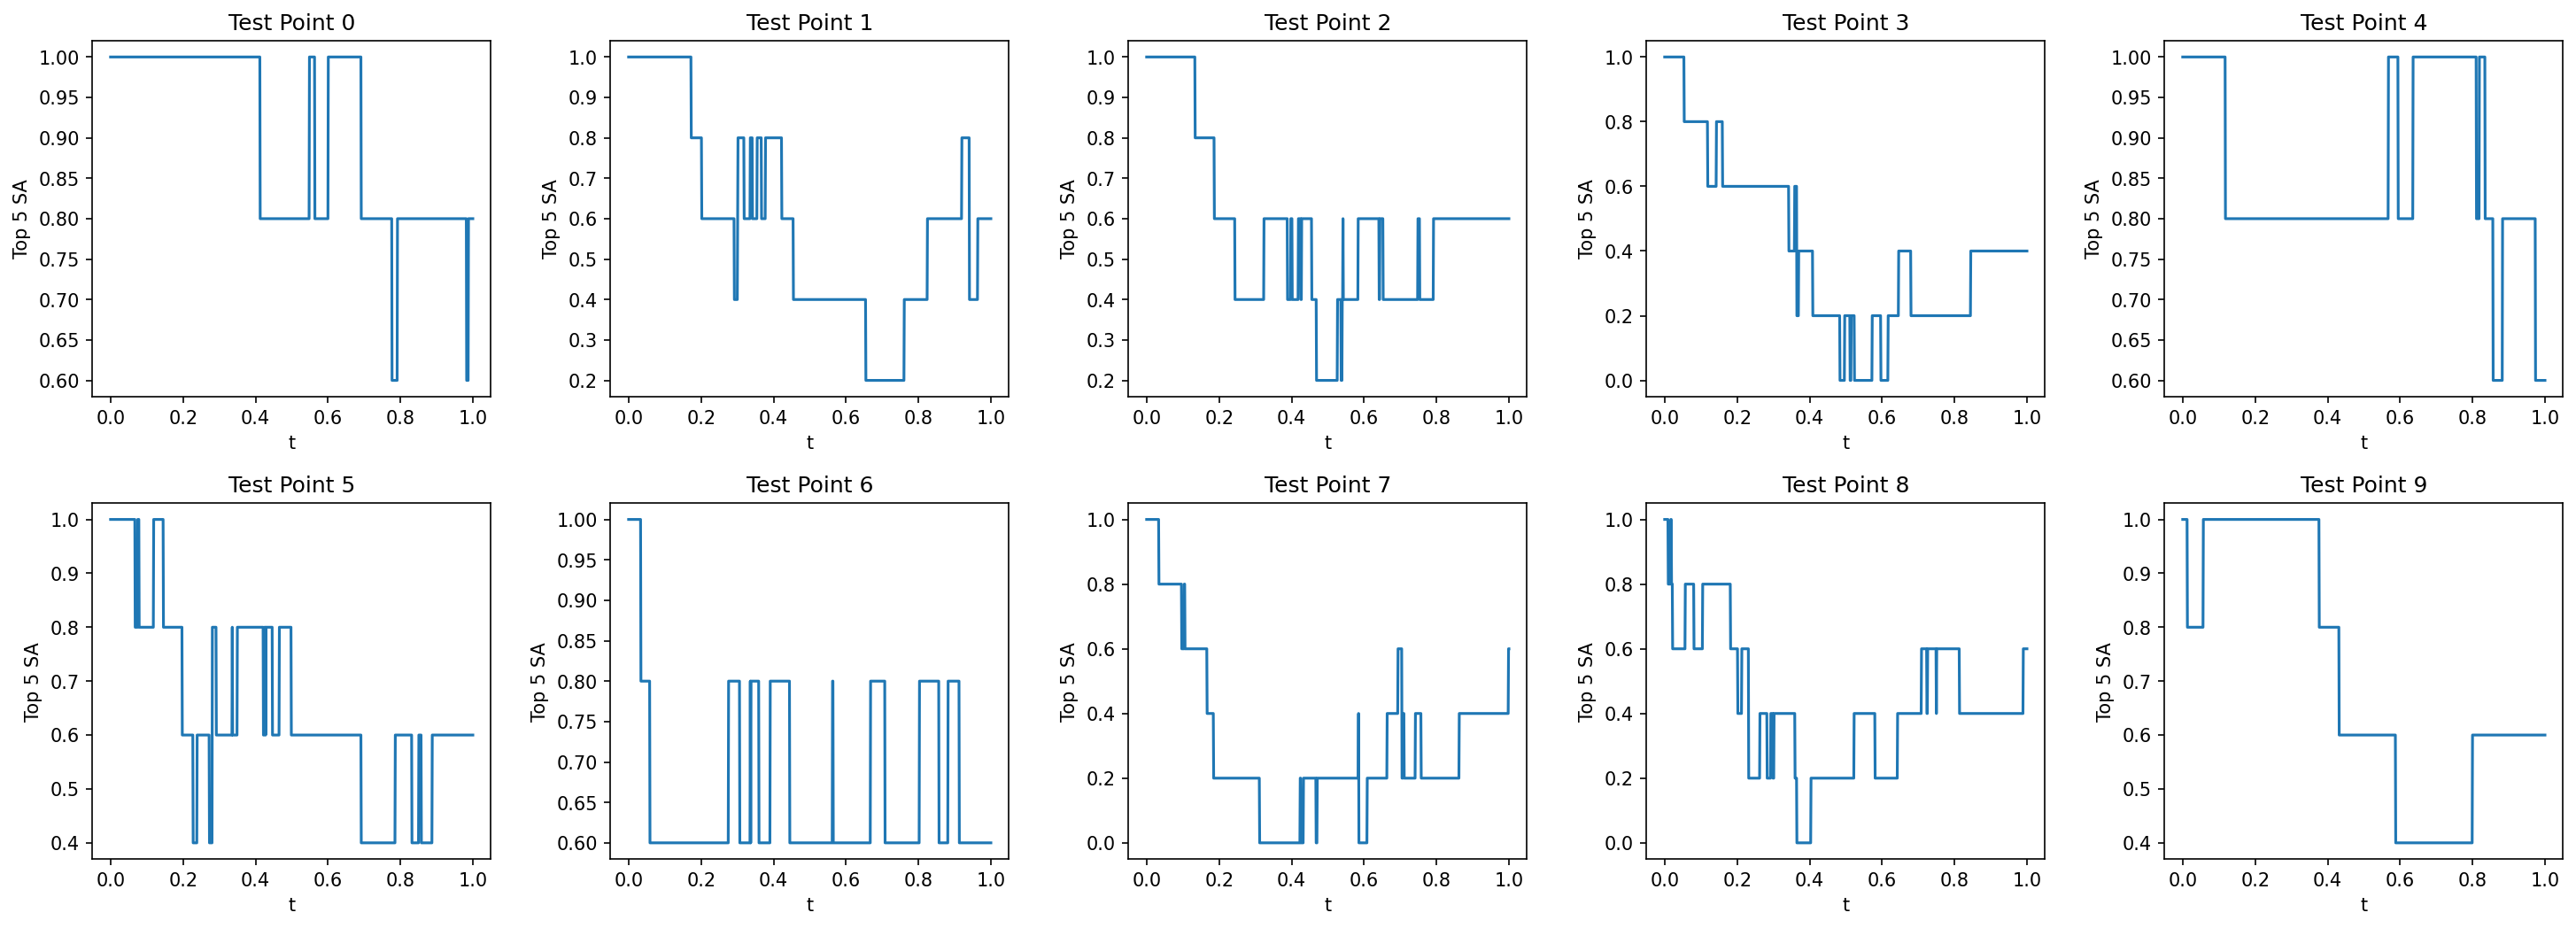

In [ ]:
test_idxs = range(10)
# Now plot the top 5 SA for each test point in a 2 rows by 5 columns grid
fig, ax = plt.subplots(2, 5, figsize=(24, 8), dpi=150)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i in range(2):
    for j in range(5):
        ax[i, j].plot(ts, tk_sa[:, test_idxs[i*5+j]])
        ax[i, j].set_xlabel('t')
        ax[i, j].set_ylabel('Top 5 SA')
        ax[i, j].set_title(f'Test Point {test_idxs[i*5+j]}')
plt.show()

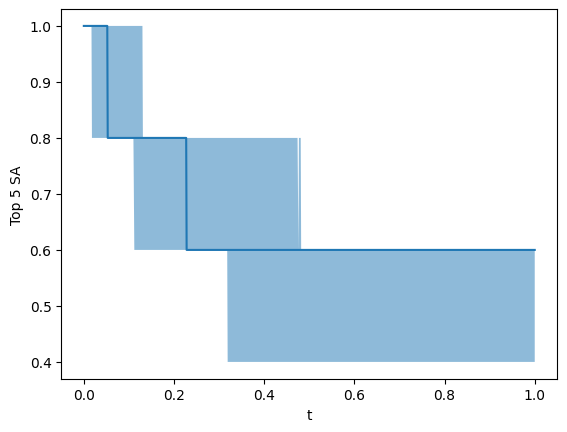

In [ ]:
q = np.quantile(tk_sa, [0.25, 0.5, 0.75], axis=1)
plt.plot(ts, q[1])
plt.fill_between(ts, q[0], q[2], alpha=0.5)
plt.xlabel('t')
plt.ylabel('Top 5 SA')
plt.show()

In [ ]:
# Load and average gradients across all models
grads = np.zeros((n_models, *X_test.shape))
for i in range(n_models):
    grads[i] = np.load(f'{directory}/{random_source}_grads_{i}.npy')
grads = grads.mean(0)

In [ ]:
tk_gt, s_gt = get_top_k(5, grads, return_sign=True)

In [ ]:
tk_curve2, s_curve2 = get_top_k(5, curve_grads2.mean(axis=0), return_sign=True)

In [ ]:
top_k_sa(tk_gt, tk_curve2, s_gt, s_curve2)

array([0.8, 0.4, 1. , ..., 0.8, 0.4, 0.8])

In [ ]:
np.quantile(top_k_sa(tk_curve, tk_curve2, s_curve, s_curve2), [0.25, 0.5, 0.75])

array([0.6, 0.6, 0.8])

# Ensembles

In [7]:
# Ensemble sizes
ensemble_sizes = [2, 3, 4, 5]

# Random source
random_source = 'rs'

# Number of ensembles to sample for each ensemble size
n_trials = 10

# Top-k features to consider
k = 5

# Store no. inputs and no. features
n_inputs, n_features = X_test.shape

In [8]:
n_te = X_test.shape[0]

# 'Average ensemble' variables (take mean of gradients across models)
topk = np.zeros((len(ensemble_sizes), n_trials, n_te, k))
signs = np.zeros((len(ensemble_sizes), n_trials, n_te, k), dtype=int)

for e, ensemble_size in enumerate(ensemble_sizes):
    print(f'Ensemble size: {ensemble_size}')
    tk = np.zeros((n_trials, ensemble_size, n_te, k))
    s = np.zeros((n_trials, ensemble_size, n_te, k), dtype=int)

    for i in tqdm(range(n_trials)):
        model_idx = np.random.choice(n_models, ensemble_size, replace=False)
        trial_curves = get_pairwise_curves(model_idx)
        curve_grads = get_curves_gradients(trial_curves)

        topk[e,i], signs[e,i] = get_top_k(k, curve_grads.mean(axis=(0,1)), return_sign=True)

Ensemble size: 2


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Ensemble size: 3


100%|██████████| 10/10 [03:07<00:00, 18.77s/it]


Ensemble size: 4


100%|██████████| 10/10 [06:12<00:00, 37.24s/it]


Ensemble size: 5


100%|██████████| 10/10 [10:22<00:00, 62.28s/it]


In [10]:
topk.shape

(4, 10, 1975, 5)

In [15]:
SA_mod = np.zeros((len(ensemble_sizes), n_te))
for i in tqdm(range(len(ensemble_sizes))):
    SA_mod[i] = average_pairwise_score(topk[i], signs[i], top_k_sa)

100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


In [18]:
%store SA_mod

Stored 'SA_mod' (ndarray)


In [21]:
10*9*0.5

45.0

In [20]:
# n choose r
from scipy.special import comb
comb(10, 2)

45.0

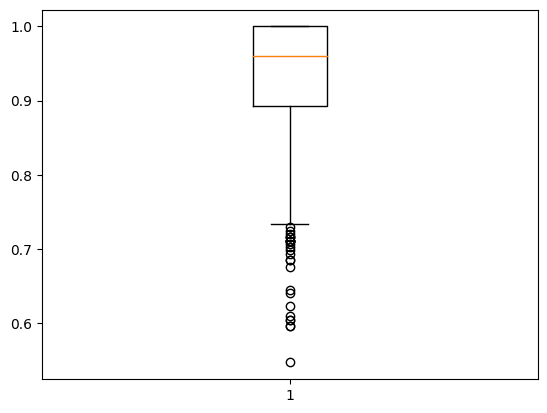

In [23]:
plt.boxplot(SA_mod[-1])
plt.show()

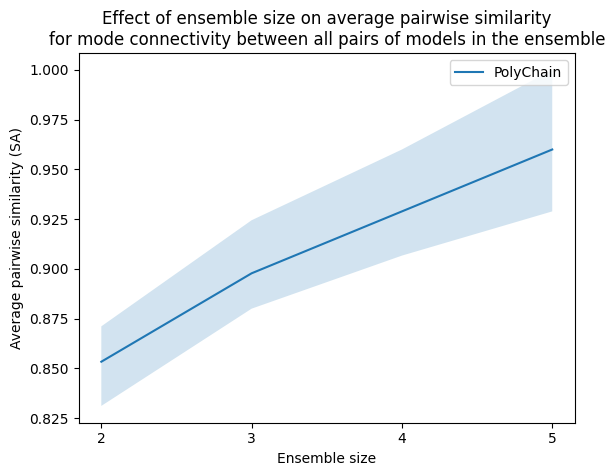

In [16]:
q = np.quantile(SA_mod, [0.4, 0.5, 0.6], axis=1)
plt.plot(ensemble_sizes, q[1], label='PolyChain')  # plot 50% quantile
plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.xticks(ensemble_sizes)
plt.ylabel('Average pairwise similarity (SA)')
plt.title('Effect of ensemble size on average pairwise similarity\nfor mode connectivity between all pairs of models in the ensemble')
plt.legend()
plt.show()

In [ ]:
top_k_sa(topk, tk_gt, signs, s_gt).mean(), np.median(top_k_sa(topk, tk_gt, signs, s_gt))

(0.819848101265823, 0.8)

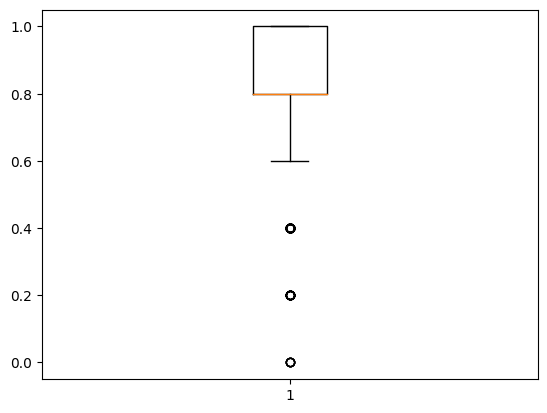

In [ ]:
plt.boxplot(top_k_sa(topk, tk_gt, signs, s_gt))
plt.show()

### Single Ensemble Size

In [31]:
# Ensemble sizes
ensemble_size = 2

# Random source
random_source = 'rs'

# Number of ensembles to sample
n_trials = 10

# Top-k features to consider
k = 5

# Store no. inputs and no. features
n_inputs, n_features = X_test.shape

# Polychain + Perturb
topk_mod_pert = np.zeros((n_trials, n_inputs, k))
signs_mod_pert = np.zeros((n_trials, n_inputs, k), dtype=int)

# Polychain
topk_mod = np.zeros((n_trials, n_inputs, k))
signs_mod = np.zeros((n_trials, n_inputs, k), dtype=int)

# Perturb
topk_pert = np.zeros((n_trials, n_inputs, k))
signs_pert = np.zeros((n_trials, n_inputs, k), dtype=int)

# Average
topk_avg = np.zeros((n_trials, n_inputs, k))
signs_avg = np.zeros((n_trials, n_inputs, k), dtype=int)

In [ ]:
for e, ensemble_size in enumerate(ensemble_sizes):
    print(f'Ensemble size: {ensemble_size}')
    tk = np.zeros((n_trials, ensemble_size, n_inputs, k))
    s = np.zeros((n_trials, ensemble_size, n_inputs, k), dtype=int)

    for i in tqdm(range(n_trials)):
        model_idx = np.random.choice(n_models, ensemble_size, replace=False)
        trial_curves = get_pairwise_curves(model_idx)
        curve_grads = get_curves_gradients(trial_curves)

        topk[e,i], signs[e,i] = get_top_k(k, curve_grads.mean(axis=(0,1)), return_sign=True)

In [ ]:
# Smooth ensemble
smooth_grads = np.zeros_like(grads)
for j in range(ensemble_size):
    for _ in range(n_weight_perturbations):
        # Add noise to layer weights
        model = model_class(*model_args)
        state_dict = torch.load(f'{directory}/{random_source}_model_{model_idx[j]}.pth')
        state_dict[layer_str] += torch.randn(state_dict[layer_str].shape) * sigma
        model.load_state_dict(state_dict)

        # Compute new gradients
        smooth_grads[j] += model.compute_gradients(x, softmax=False, label=1, return_numpy=True)
smooth_grads /= n_weight_perturbations